# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [3]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [4]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [5]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [19]:
train_paths = glob('C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/train/*.png')
test_paths = glob('C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/test/*.png')

In [21]:
path = train_paths[0]
path

'C:/Users/신상훈/Desktop/새 폴더/dataset/cifar/train\\0_frog.png'

In [25]:
def get_class_name(path):
    fname = tf.strings.split(path,'_')[-1]
    lbl_name = tf.strings.regex_replace(fname,'.png','')
    return lbl_name

In [26]:
class_names = [get_class_name(path) for path in train_paths]

In [27]:
class_names

[<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'automobile'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'airplane'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'truck'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'airplane'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: shape=(), dtype=strin

In [30]:
classes = tf.unique(class_names).y.numpy()
classes

array([b'frog', b'automobile', b'ship', b'cat', b'deer', b'airplane',
       b'truck', b'dog', b'bird', b'horse'], dtype=object)

In [31]:
classes == get_class_name(path)

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False])>

In [38]:
tf.cast(classes == get_class_name(path),tf.uint8)

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)>

In [39]:
onehot_encoding = tf.cast(classes == get_class_name(path),tf.uint8)

In [40]:
def onehot_encoding(label_names):
    classes == get_class_name(path)
    onehot_encoding = tf.cast(classes == get_class_name(path),tf.uint8)
    return onehot_encoding

In [62]:
def read_dataset(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    image = tf.cast(image, tf.float32) / 255.
    # read label
    class_name = get_class_name(path)
    label = onehot_encoding(class_name)
    return image, label

In [47]:
image, label = read_dataset(path)
image.shape , label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [ ]:
tf.image = tf.image.random_flip_left_right(image)

In [50]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image , label

In [53]:
tranformed, label = image_preprocess(image, label)

In [54]:
tranformed.shape

TensorShape([32, 32, 3])

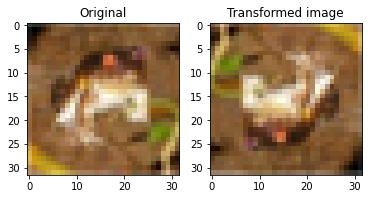

In [56]:
plt.subplot(121)
plt.title('Original')
plt.imshow(image)

plt.subplot(122)
plt.title('Transformed image')
plt.imshow(tranformed)
plt.show()

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess) #trainsform images
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

In [64]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size = len(train_paths))
test_dataset = test_dataset.repeat()

## Training

In [66]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [ ]:
model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data = test_dataset,
    validation_steps = validation_steps,
    epochs = num_epochs)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
